# 1.预处理HR fathers数据集

In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import random

from torch.utils.data import Dataset, Sampler, DataLoader, WeightedRandomSampler
from torchvision import transforms as T
from torchvision.transforms import functional as F

import numpy as np

(481, 321)


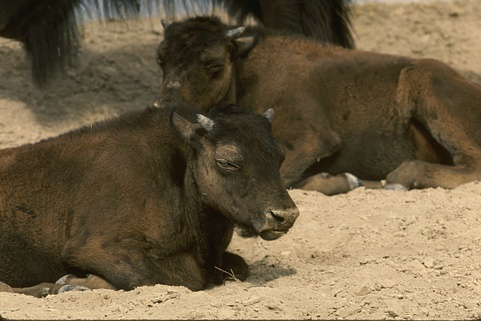

In [3]:
# 查看原图
path = '/content/drive/MyDrive/Colab Notebooks/ZSSR/'
src_img  = Image.open(path + 'images/input.jpg')
print(src_img.size)
src_img

## 1.1.自定义Dataset

In [4]:
class ZSSRDataset(Dataset):
    """
    pytorch的Dataset类继承，生成不同大小的HR fathers数据集，主要用于后面输入pytorch进行训练
    """
    def __init__(self, src_img):
        super(Dataset, self).__init__()
        self.src_img = src_img
        im_height = self.src_img.size[0]
        im_width = self.src_img.size[1]
        
        angles = [0, 90, 180, 270]

        zoom_factors = []
        # 循环降采样系数，从原图高度 // 5 -> 原图高度 + 1
        for i in range(im_height // 5, im_height + 1):
            downsampled_height = i
            zoom = float(downsampled_height / im_height)  # 计算缩放比例
            zoom_factors.append(zoom)
            
        hres_list = []
        # 对所有缩放比例下，计算原图通过双三次差值求得的降采样图，
        # 并对每个降采样图进行旋转、翻转等扩展数据集操作
        for zoom in zoom_factors:
            hres = self.src_img.resize(
                (int(im_height * zoom), int(im_width * zoom)), 
                resample=Image.BICUBIC
            )
            #hres = F.pil_to_tensor(hres)
            for angle in angles:
                r_img = F.rotate(hres, angle)
                hres_list.append(r_img)
                hres_list.append(F.vflip(r_img))
                hres_list.append(F.hflip(r_img))
        self.hres_list = hres_list
        
    def __getitem__(self, index):
        return self.hres_list[index]
    
    def __len__(self):
        return len(self.hres_list)
    
    def concat(self, dataset):
        """
        连接多个Dataset
        """
        self.hres_list += dataset.hres_list
        return self

In [5]:
# 获取scr_img的HR fathers数据
test_dataset = ZSSRDataset(src_img)
print("HR fathers数量：", len(test_dataset))
print("第10个HR father的尺寸：", test_dataset[10].size)

HR fathers数量： 4632
第10个HR father的尺寸： (96, 64)


## 1.2.自定义根据概率进行选择的Sampler

In [6]:
class ZSSRSampler(Sampler):
    """
    继承自pytorch的Sampler类
    通过计算每个HR fathers和原图的面积大小比例，比例越接近，则被选中的概率越大
    """
    def __init__(self, dataset, batch_size):
        super(ZSSRSampler, self).__init__(dataset)
        self.dataset = dataset
        self.batch_size = batch_size
        # 原图面积
        src_img_area = float(dataset.src_img.size[0] * dataset.src_img.size[1])
        # 获取Dataset里面所有图片面积与原图片的面积比值, 面积比值越大则被选中的概率就越大
        self.pair_probabilities = np.float32(
            [(hres.size[0]*hres.size[1] / src_img_area) for hres in self.dataset.hres_list]
        )
        
    def __iter__(self):
        while True:
            yield random.choices(self.dataset, weights=self.pair_probabilities, k=self.batch_size)


sampler中一个batch的长度为： 8
batch中某个元素为预处理后的HR father：


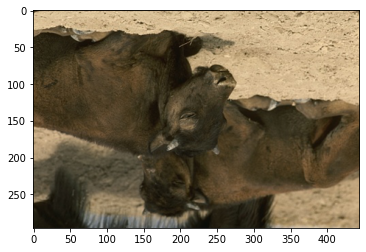

In [16]:
# 得到batch_size大小的sampler
batch_size = 8
test_sampler = ZSSRSampler(test_dataset, batch_size)
# 遍历sampler输出第一个batch的长度
for iter, hres in enumerate(test_sampler):
    print("sampler中一个batch的长度为：", len(hres))
    print("batch中某个元素为预处理后的HR father：")
    plt.imshow(hres[3])
    plt.show()
    if iter == 0:
        break

# 2.CNN模型

In [8]:
import torch 
import torch.nn as nn
from math import sqrt

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ZSSRnet(nn.Module):
    def __init__(self, input_channels=3, channels=128, kernel_size=3):
        super(ZSSRnet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=channels, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.conv3 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.conv4 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.conv5 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.conv6 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.conv7 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.conv8 = nn.Conv2d(in_channels=channels, out_channels=input_channels, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.relu = nn.ReLU(inplace=True)

        # 使用正态分布来初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))

    def forward(self, input_img):
        x = self.conv1(self.relu(input_img))
        x = self.conv2(self.relu(x))
        x = self.conv3(self.relu(x))
        x = self.conv4(self.relu(x))
        x = self.conv5(self.relu(x))
        x = self.conv6(self.relu(x))
        x = self.conv7(self.relu(x))
        residual = self.conv8(self.relu(x))
        return residual + input_img

# 3.训练过程

In [10]:
from PIL import ImageFilter
import tqdm
from skimage import transform


In [11]:
def bicubic_resample(lres, sf, hres=None):
    """
    使用双三次插值法进行resize
    """
    if hres is None:
        lres_inter = lres.resize([round(lres.size[0] * sf), round(lres.size[1] * sf)], resample=Image.BICUBIC)
        return lres_inter
    else:
        lres_inter = lres.resize([round(lres.size[0] * sf), round(lres.size[1] * sf)], resample=Image.BICUBIC)
        if lres_inter.size[0] == hres.size[0] and lres_inter.size[1] == hres.size[1]:
            return lres_inter
        else: 
            lres_inter = lres.resize([hres.size[0], hres.size[1]], resample=Image.BICUBIC)
            return lres_inter

def adjust_learning_rate(optimizer, new_lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def forward(lres_interpolated, model):
    hres_forward = model(lres_interpolated)
    
    hres_cpu = hres_forward.cpu().detach().permute(0, 2, 3, 1).numpy()
    # print(hres_cpu.shape)

    return np.clip(np.squeeze(hres_cpu), 0, 1)

def back_projection(hres_out, lres_in, sf, resample_method):
    """
    back projection算法
    """
    lres_from_hres = resample_method(hres_out, 1.0/sf, lres_in)
    lres_from_hres_tensor = T.ToTensor()(lres_from_hres)
    lres_in_tensor = T.ToTensor()(lres_in)
    residual_back_projection = lres_in_tensor - lres_from_hres_tensor
    residual_back_projection = residual_back_projection.permute(1, 2, 0).numpy()

    residual_out = transform.resize(residual_back_projection,(hres_out.size[1], hres_out.size[0]), order=3)
    
    residual_out_tensor = T.ToTensor()(residual_out)
    hres_out_tensor = T.ToTensor()(hres_out)

    hres_final_tensor = residual_out_tensor + hres_out_tensor

    hres_final = np.clip(hres_final_tensor.numpy(), 0, 1)
    hres_final_tensor = T.ToTensor()(hres_final).permute(1, 2, 0)
    hres_final = T.ToPILImage()(hres_final_tensor)

    return hres_final

In [12]:
def train(im_input, model, data_sampler, num_batches, s_factor, device):
    crop_size = 64

    # 先将原图根据双三次插值法进行按比例缩小，然后再放大得到原图对应的son
    input_downscale = bicubic_resample(im_input, 1.0/s_factor)
    interpolated_input_son = bicubic_resample(input_downscale, s_factor, im_input)
    input_son = F.to_tensor(interpolated_input_son)
    
    average_loss = 0
    learning_rate = 0.001

    loss = nn.MSELoss() # MSE Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    run_adjust = 50
    run_test = True
    run_test_every = 50
    # Params concerning learning rate policy
    learning_rate_change_ratio = 1.5  # ratio between STD and slope of linear fit, under which lr is reduced
    learning_rate_policy_check_every = 60
    learning_rate_slope_range = 256
    learning_rate_change_iter_nums = [0]
    min_iters = 256
    
    # start iteration
    mse_reconstruct = []
    mse_steps = []
    # iter = 0
    with tqdm.tqdm(total=num_batches, miniters=1, mininterval=0) as progress:
        for iter, hres in enumerate(data_sampler):
            optimizer.zero_grad()

            h_fathers = []
            l_sons = []
            # 对hres中的每个HR father进行转为tensor和随机截取一个64*64的区域
            # 并通过双三次插值获得对应的LR son
            for h in hres:
                trans = T.Compose([
                    T.RandomCrop(crop_size)
                ])
                h = trans(h)  # 随机截取64*64的大小
                
                l = bicubic_resample(h, 1.0/s_factor)
                l = bicubic_resample(l, s_factor, h)
                # some tricks
                l = l.filter(ImageFilter.GaussianBlur(radius=4))
                h = h.filter(ImageFilter.SHARPEN)
                
                h_fathers.append(F.to_tensor(h).numpy())
                l_sons.append(F.to_tensor(l).numpy())

            h_fathers = torch.tensor(h_fathers).to(device)
            l_sons = torch.tensor(l_sons).to(device)

            h_fathers_predicted = model(l_sons)
            error = loss(h_fathers_predicted, h_fathers)
            average_loss += error.item()
            error.backward()
            optimizer.step()
            
            # adjust learning rate
            if run_test and (not iter % run_test_every):
                reconstructed_im = forward(input_son.unsqueeze(0).to(device), model)
                mse_reconstruct.append(np.mean(np.ndarray.flatten(np.square(im_input - reconstructed_im))))
                mse_steps.append(iter)
            if (not (1 + iter) % learning_rate_policy_check_every and iter - learning_rate_change_iter_nums[-1] > min_iters):
                # noinspection PyTupleAssignmentBalance
                #print(self.conf.run_test_every)
                [slope, _], [[var, _], _] = np.polyfit(mse_steps[-(learning_rate_slope_range //
                                                                        run_adjust):],
                                                        mse_reconstruct[-(learning_rate_slope_range //
                                                                        run_adjust):],
                                                        1, cov=True)

                # We take the the standard deviation as a measure
                std = np.sqrt(var)

                # Verbose
                # print('slope: ', slope, 'STD: ', std)

                # Determine learning rate maintaining or reduction by the ration between slope and noise
                if -learning_rate_change_ratio * slope < std:
                    learning_rate /= 10
                    adjust_learning_rate(optimizer, learning_rate)
                    print("learning rate updated: ", learning_rate)

                    # Keep track of learning rate changes for plotting purposes
                    learning_rate_change_iter_nums.append(iter)

            if iter > num_batches or learning_rate < 9e-6:
                print('Training is over.')
                average_loss /= iter
                print('Average Loss is {average_loss}'.format(average_loss=average_loss))
#                 out = final_output(im_input, model, resample, s_factor, back_projection)
#                 final_zssr.save('zssr.png')
                break

            progress.set_description("Iteration: {iter} Loss: {loss}, Learning Rate: {lr} ".format( \
                iter=iter, loss=error.data.cpu().numpy(), lr=learning_rate))
            progress.update()

In [18]:
def final_output(im_input, model, resample_method, sf, back_projection):
    outputs = []
    # im_input = im_input.filter(ImageFilter.SHARPEN)

    for k in range(0, 8):
        test_input = np.rot90(im_input, k) if k < 4 else np.fliplr(np.rot90(im_input, k))
        test_input = Image.fromarray(test_input)
        interpolated_test_input = resample_method(test_input, sf)
        interpolated_test_input = T.ToTensor()(interpolated_test_input).unsqueeze(0).to(device)
        temp_out = forward(interpolated_test_input, model)
        
        temp_out = np.rot90(temp_out, -k) if k < 4 else np.rot90(np.fliplr(temp_out), -k)
        temp_out = temp_out.copy()
        temp_out = T.ToTensor()(temp_out)
        temp_out = T.ToPILImage()(temp_out)
        # temp_out.save('zssr_init_'+k)

        for bp_iter in range(12):
            temp_out = back_projection(temp_out, im_input, sf, resample_method)

        temp_out.save(path + 'test_result/zssr_init_'+'%d' % k +'.png')
        temp_out = np.array(temp_out)
        outputs.append(temp_out)
        

    out_median = np.clip(np.median(outputs, 0) / 255, 0, 1)
    out_median = T.ToTensor()(out_median)
    out_median = T.ToPILImage()(out_median)
    out_median.save(path + 'test_result/out_median.png')
    # im_input = im_input.filter(ImageFilter.SHARPEN)
    for bp_iter in range(10):
        out_median = back_projection(out_median, im_input, sf, resample_method)

    return out_median, outputs

In [19]:
num_batches = 3000
s_factor = 2

model = ZSSRnet()
model.to(device)

train(src_img,
      model,
      test_sampler,
      num_batches,
      s_factor,
      device)

torch.save(model, path + 'model/zssr_x2.pt')

hres_false = bicubic_resample(src_img, s_factor)
hres_false.save(path + 'result/zssr_x2_interpolated.png')

model = torch.load(path + 'model/zssr_x2.pt')
final_zssr, outputs = final_output(src_img, model, bicubic_resample, s_factor, back_projection)
final_zssr.save(path + 'result/zssr_x2_net_out.png')

Iteration: 301 Loss: 0.003134925616905093, Learning Rate: 0.0001 :  10%|█         | 302/3000 [00:16<02:56, 15.33it/s]

learning rate updated:  0.0001


Iteration: 661 Loss: 0.004864129703491926, Learning Rate: 1e-05 :  22%|██▏       | 662/3000 [00:36<02:25, 16.07it/s]

learning rate updated:  1e-05


Iteration: 1078 Loss: 0.003966599702835083, Learning Rate: 1e-05 :  36%|███▌      | 1079/3000 [00:58<01:44, 18.47it/s]


learning rate updated:  1.0000000000000002e-06
Training is over.
Average Loss is 0.00605348042767854


# 4.其他例子

In [27]:
# 获取原图
path = '/content/drive/MyDrive/Colab Notebooks/ZSSR/'
for i in range(1, 6):
    input_img_name = 'input' + str(i) + '.jpg'
    src_img  = Image.open(path + 'images/' + input_img_name)
    print(src_img.size)

    # 获取scr_img的HR fathers数据
    test_dataset = ZSSRDataset(src_img)
    print("HR fathers数量：", len(test_dataset))
    print("第10个HR father的尺寸：", test_dataset[10].size)

    # 得到batch_size大小的sampler
    batch_size = 8
    test_sampler = ZSSRSampler(test_dataset, batch_size)

    num_batches = 3000
    s_factor = 2

    model = ZSSRnet()
    model.to(device)

    train(src_img,
          model,
          test_sampler,
          num_batches,
          s_factor,
          device)
    
    name_head = 'test' + str(i)
    torch.save(model, path + 'model/' + name_head + '_zssr_x2.pt')

    hres_false = bicubic_resample(src_img, s_factor)
    hres_false.save(path + 'result/' + name_head + '_zssr_x2_interpolated.png')

    model = torch.load(path + 'model/' + name_head + '_zssr_x2.pt')
    final_zssr, outputs = final_output(src_img, model, bicubic_resample, s_factor, back_projection)
    final_zssr.save(path + 'result/' + name_head + '_zssr_x2_net_out.png')

(481, 321)
HR fathers数量： 4632
第10个HR father的尺寸： (96, 64)


Iteration: 301 Loss: 0.0161416195333004, Learning Rate: 0.0001 :  10%|█         | 302/3000 [00:17<03:01, 14.88it/s]

learning rate updated:  0.0001


Iteration: 601 Loss: 0.016993632540106773, Learning Rate: 1e-05 :  20%|██        | 602/3000 [00:33<02:40, 14.95it/s]

learning rate updated:  1e-05


Iteration: 898 Loss: 0.00913393683731556, Learning Rate: 1e-05 :  30%|██▉       | 899/3000 [00:50<01:57, 17.90it/s]


learning rate updated:  1.0000000000000002e-06
Training is over.
Average Loss is 0.02414098690088851
(481, 321)
HR fathers数量： 4632
第10个HR father的尺寸： (96, 64)


Iteration: 301 Loss: 0.02468138001859188, Learning Rate: 0.0001 :  10%|█         | 302/3000 [00:16<02:56, 15.30it/s]

learning rate updated:  0.0001


Iteration: 601 Loss: 0.02024715393781662, Learning Rate: 1e-05 :  20%|██        | 602/3000 [00:31<02:40, 14.96it/s]

learning rate updated:  1e-05


Iteration: 898 Loss: 0.02424672059714794, Learning Rate: 1e-05 :  30%|██▉       | 899/3000 [00:47<01:51, 18.87it/s]


learning rate updated:  1.0000000000000002e-06
Training is over.
Average Loss is 0.02762268036210265
(321, 481)
HR fathers数量： 3096
第10个HR father的尺寸： (64, 95)


Iteration: 301 Loss: 0.024144692346453667, Learning Rate: 0.0001 :  10%|█         | 302/3000 [00:15<03:02, 14.78it/s]

learning rate updated:  0.0001


Iteration: 601 Loss: 0.019173789769411087, Learning Rate: 1e-05 :  20%|██        | 602/3000 [00:31<02:40, 14.94it/s]

learning rate updated:  1e-05


Iteration: 898 Loss: 0.020152833312749863, Learning Rate: 1e-05 :  30%|██▉       | 899/3000 [00:47<01:50, 18.96it/s]


learning rate updated:  1.0000000000000002e-06
Training is over.
Average Loss is 0.03259550931410775
(481, 321)
HR fathers数量： 4632
第10个HR father的尺寸： (96, 64)


Iteration: 301 Loss: 0.00543637853115797, Learning Rate: 0.0001 :  10%|█         | 302/3000 [00:16<02:58, 15.14it/s]

learning rate updated:  0.0001


Iteration: 601 Loss: 0.011324763298034668, Learning Rate: 1e-05 :  20%|██        | 602/3000 [00:32<02:44, 14.55it/s]

learning rate updated:  1e-05


Iteration: 898 Loss: 0.010977606289088726, Learning Rate: 1e-05 :  30%|██▉       | 899/3000 [00:48<01:53, 18.56it/s]


learning rate updated:  1.0000000000000002e-06
Training is over.
Average Loss is 0.012409885030512276
(481, 321)
HR fathers数量： 4632
第10个HR father的尺寸： (96, 64)


Iteration: 361 Loss: 0.007603473961353302, Learning Rate: 0.0001 :  12%|█▏        | 362/3000 [00:19<02:44, 16.08it/s]

learning rate updated:  0.0001


Iteration: 661 Loss: 0.009001389145851135, Learning Rate: 1e-05 :  22%|██▏       | 662/3000 [00:35<02:20, 16.59it/s]

learning rate updated:  1e-05


Iteration: 958 Loss: 0.006528464611619711, Learning Rate: 1e-05 :  32%|███▏      | 959/3000 [00:50<01:48, 18.82it/s]


learning rate updated:  1.0000000000000002e-06
Training is over.
Average Loss is 0.009608055586558577


# 5.结果截取

In [2]:
from matplotlib import pyplot as plt

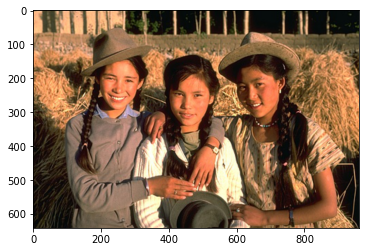

In [5]:
test1_bicubic = plt.imread('./result/test1_zssr_x2_interpolated.png')

plt.imshow(test1_bicubic)
plt.show()

In [7]:
test1_bicubic = plt.imread('./result/test1_zssr_x2_interpolated.png')
test1_zssr = plt.imread('./result/test1_zssr_x2_net_out.png')
test2_bicubic = plt.imread('./result/test2_zssr_x2_interpolated.png')
test2_zssr = plt.imread('./result/test2_zssr_x2_net_out.png')
test3_bicubic = plt.imread('./result/test3_zssr_x2_interpolated.png')
test3_zssr = plt.imread('./result/test3_zssr_x2_net_out.png')
test4_bicubic = plt.imread('./result/test4_zssr_x2_interpolated.png')
test4_zssr = plt.imread('./result/test4_zssr_x2_net_out.png')
test5_bicubic = plt.imread('./result/test5_zssr_x2_interpolated.png')
test5_zssr = plt.imread('./result/test5_zssr_x2_net_out.png')

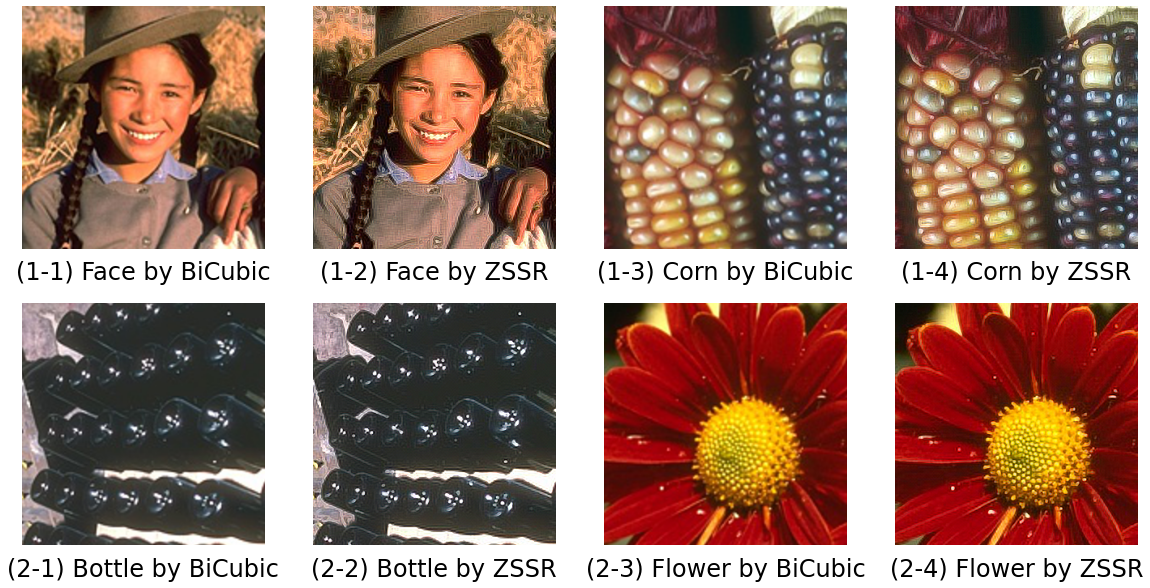

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=4, constrained_layout=False)
fig.set_size_inches(20, 10)

axs[0, 0].imshow(test1_bicubic[100:400, 100:400])
axs[0, 0].set_axis_off()
axs[0, 0].set_title('(1-1) Face by BiCubic', y=-0.15, fontdict={'fontsize': 24})
axs[0, 1].imshow(test1_zssr[100:400, 100:400])
axs[0, 1].set_axis_off()
axs[0, 1].set_title('(1-2) Face by ZSSR', y=-0.15, fontdict={'fontsize': 24})

axs[0, 2].imshow(test2_bicubic[100:400, 100:400])
axs[0, 2].set_axis_off()
axs[0, 2].set_title('(1-3) Corn by BiCubic', y=-0.15, fontdict={'fontsize': 24})
axs[0, 3].imshow(test2_zssr[100:400, 100:400])
axs[0, 3].set_axis_off()
axs[0, 3].set_title('(1-4) Corn by ZSSR', y=-0.15, fontdict={'fontsize': 24})

axs[1, 0].imshow(test3_bicubic[300:600, 300:600])
axs[1, 0].set_axis_off()
axs[1, 0].set_title('(2-1) Bottle by BiCubic', y=-0.15, fontdict={'fontsize': 24})
axs[1, 1].imshow(test3_zssr[300:600, 300:600])
axs[1, 1].set_axis_off()
axs[1, 1].set_title('(2-2) Bottle by ZSSR', y=-0.15, fontdict={'fontsize': 24})

axs[1, 2].imshow(test5_bicubic[100:400, 100:400])
axs[1, 2].set_axis_off()
axs[1, 2].set_title('(2-3) Flower by BiCubic', y=-0.15, fontdict={'fontsize': 24})
axs[1, 3].imshow(test5_zssr[100:400, 100:400])
axs[1, 3].set_axis_off()
axs[1, 3].set_title('(2-4) Flower by ZSSR', y=-0.15, fontdict={'fontsize': 24})

# save the result
plt.savefig("summary_comparision.png", bbox_inches='tight', pad_inches=0)
plt.show()